In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [6]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [7]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.580055])

In [8]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [9]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.444429
 stars         0.403077
 quixotic      0.075380
 merciful      0.035531
 fireman       0.034485
 touch         0.001058
 nonchalant    0.000617
 cute          0.000483
 barbarous     0.000423
 wrap          0.000414
 lethal        0.000410
 shelf         0.000403
 rigid         0.000358
 change        0.000352
 sweltering    0.000299
 damp          0.000288
 lip           0.000279
 rain          0.000278
 clammy        0.000241
 playground    0.000240
 eight         0.000219
 dependent     0.000198
 future        0.000198
 adhesive      0.000189
 offer         0.000149
 dtype: float64}

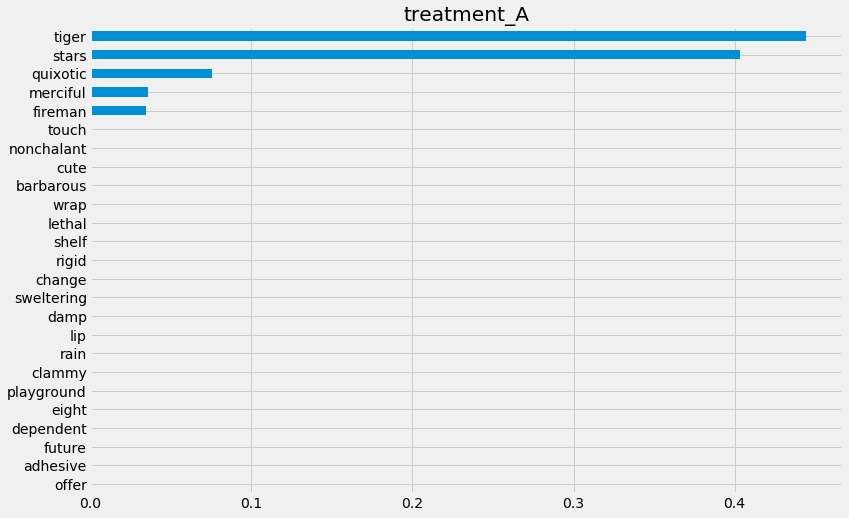

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [11]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.926826
 stars         0.890637
 quixotic      0.152119
 fireman       0.067351
 merciful      0.065483
 touch         0.000955
 cute          0.000355
 wrap          0.000243
 nonchalant    0.000172
 shelf         0.000122
 change        0.000102
 playground    0.000094
 offer         0.000068
 sweltering    0.000068
 lethal        0.000040
 future        0.000020
 adhesive      0.000014
 lip           0.000012
 rigid        -0.000012
 barbarous    -0.000013
 dependent    -0.000021
 damp         -0.000025
 rain         -0.000047
 eight        -0.000060
 clammy       -0.000266
 dtype: float64}

In [12]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.7701990604400635 seconds


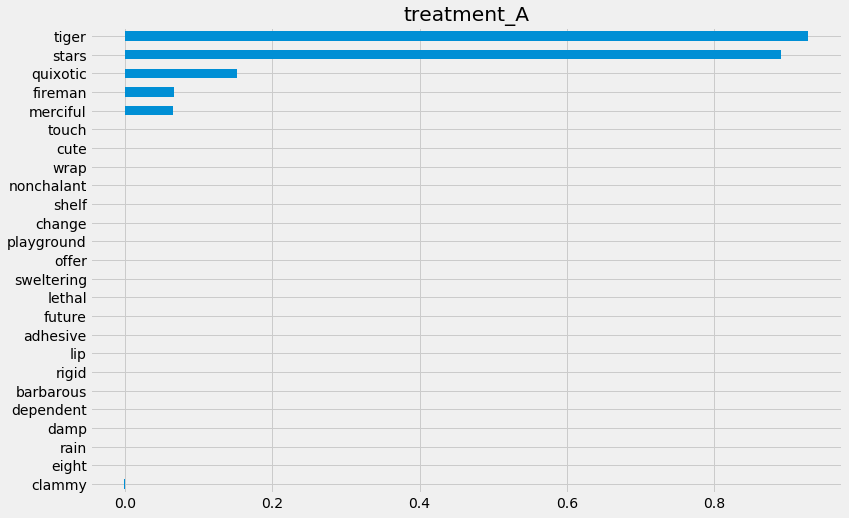

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [14]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.6549179553985596 seconds


In [15]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.926826
stars         0.890637
quixotic      0.152119
fireman       0.067351
merciful      0.065483
touch         0.000955
cute          0.000355
wrap          0.000243
nonchalant    0.000172
shelf         0.000122
change        0.000102
playground    0.000094
offer         0.000068
sweltering    0.000068
lethal        0.000040
future        0.000020
adhesive      0.000014
lip           0.000012
rigid        -0.000012
barbarous    -0.000013
dependent    -0.000021
damp         -0.000025
rain         -0.000047
eight        -0.000060
clammy       -0.000266
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

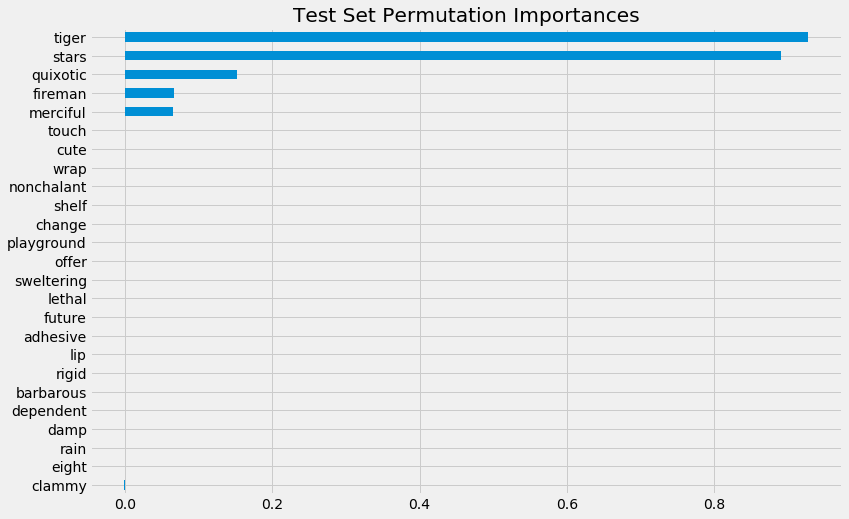

In [16]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [17]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

tiger         0.932121
stars         0.914533
quixotic      0.150311
fireman       0.070200
merciful      0.068532
change        0.002079
touch         0.002075
wrap          0.001549
barbarous     0.001534
nonchalant    0.001475
lethal        0.001265
shelf         0.001234
cute          0.001149
lip           0.001064
eight         0.001002
clammy        0.000985
damp          0.000899
sweltering    0.000822
playground    0.000816
rain          0.000799
adhesive      0.000706
offer         0.000696
rigid         0.000646
dependent     0.000599
future        0.000571
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

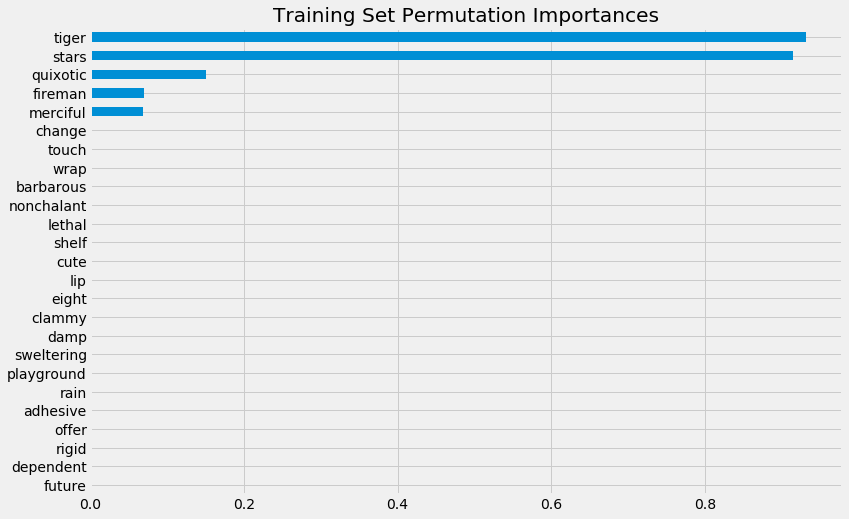

In [18]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 1.63713247e-01, -1.22875268e-01,  1.29921780e-02, ...,
          4.77270166e-04,  8.78739522e-05,  4.47276414e-04],
        [ 1.07458801e-01,  1.68045837e-01, -5.38344956e-02, ...,
          1.48115054e-04, -4.79806857e-04,  3.88284913e-04],
        [ 1.52838059e-01,  4.27213750e-02, -2.98603942e-02, ...,
         -1.93728476e-03,  4.20645535e-04,  1.67141631e-04],
        ...,
        [ 2.10088221e-01,  2.58206832e-01,  1.36663409e-02, ...,
         -2.33767724e-05, -5.13345087e-05, -1.09709454e-04],
        [ 1.43487246e-01, -2.19807727e-01,  1.57069559e-02, ...,
          9.23352141e-05,  8.12460244e-05,  2.27814358e-04],
        [ 1.39723722e-01,  9.35043735e-02,  2.40665358e-02, ...,
         -1.16384901e-05,  1.65545219e-04,  1.08785894e-04]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.13124822, 0.13219818, 0.02059032, 0.03700333, 0.01741701,
       0.00032722, 0.00081558, 0.00268428, 0.00085818, 0.00024359,
       0.00090127, 0.00081984, 0.00034884, 0.00067194, 0.00082475,
       0.00068499, 0.0007342 , 0.00130267, 0.00042108, 0.00045903,
       0.00049161, 0.00090679, 0.00049228, 0.00043198, 0.00056552])

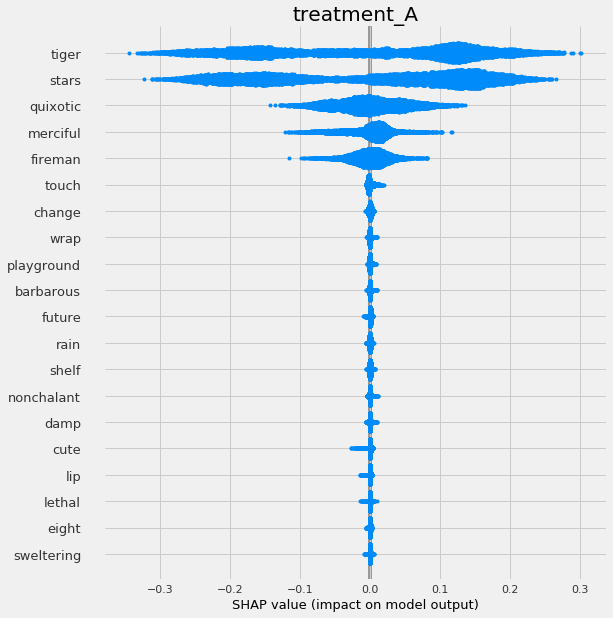

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

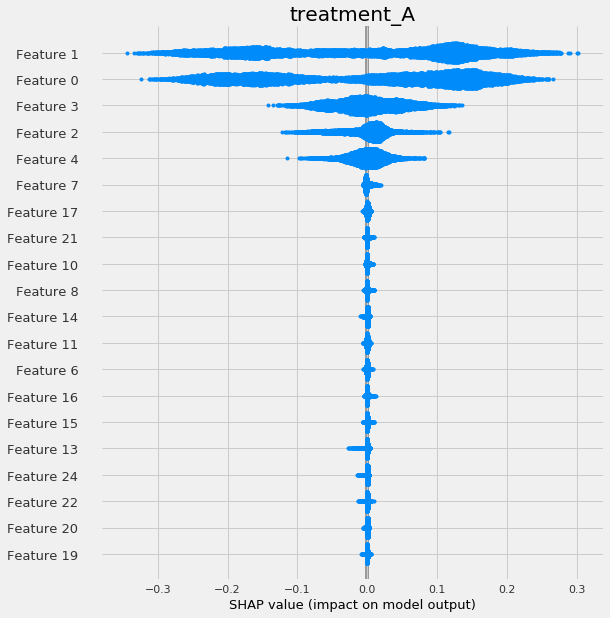

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

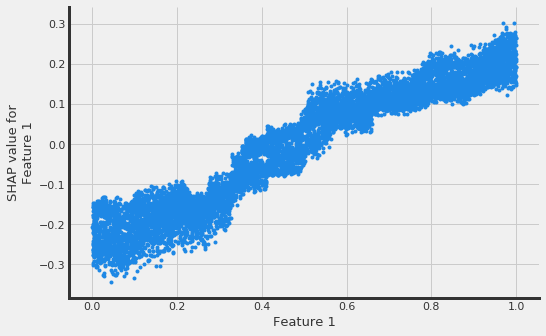

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

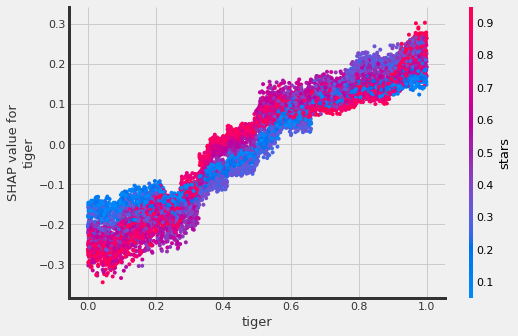

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

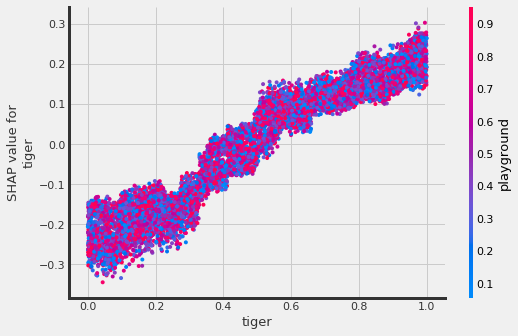

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [26]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.58065275]), array([0.56617032]), array([0.59513517]))

In [27]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [28]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.340037
 stars         0.294991
 quixotic      0.053629
 merciful      0.051621
 fireman       0.035279
 change        0.021800
 touch         0.018210
 eight         0.013965
 barbarous     0.013783
 nonchalant    0.013619
 cute          0.013341
 wrap          0.013082
 dependent     0.012694
 offer         0.010826
 clammy        0.010642
 adhesive      0.009580
 rain          0.009102
 lethal        0.009055
 sweltering    0.008511
 future        0.008493
 playground    0.008492
 rigid         0.008428
 damp          0.007731
 shelf         0.007184
 lip           0.005906
 dtype: float64}

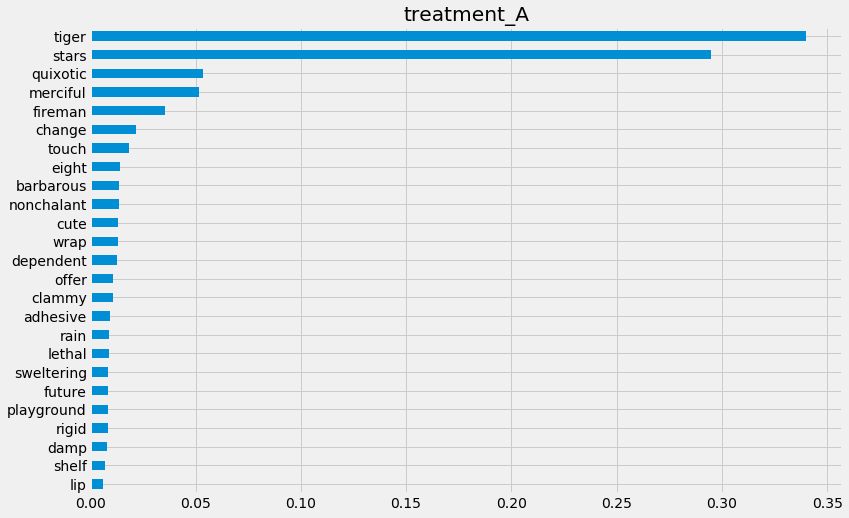

In [29]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [30]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.542145
 stars         0.467867
 merciful      0.052725
 quixotic      0.052160
 fireman       0.028023
 change        0.016190
 touch         0.010718
 nonchalant    0.008626
 eight         0.007869
 dependent     0.007420
 wrap          0.006913
 offer         0.005693
 clammy        0.005449
 playground    0.005034
 lethal        0.004923
 cute          0.004634
 future        0.004429
 sweltering    0.004285
 barbarous     0.004236
 shelf         0.003853
 damp          0.003703
 rain          0.003322
 adhesive      0.002478
 lip           0.001463
 rigid        -0.000175
 dtype: float64}

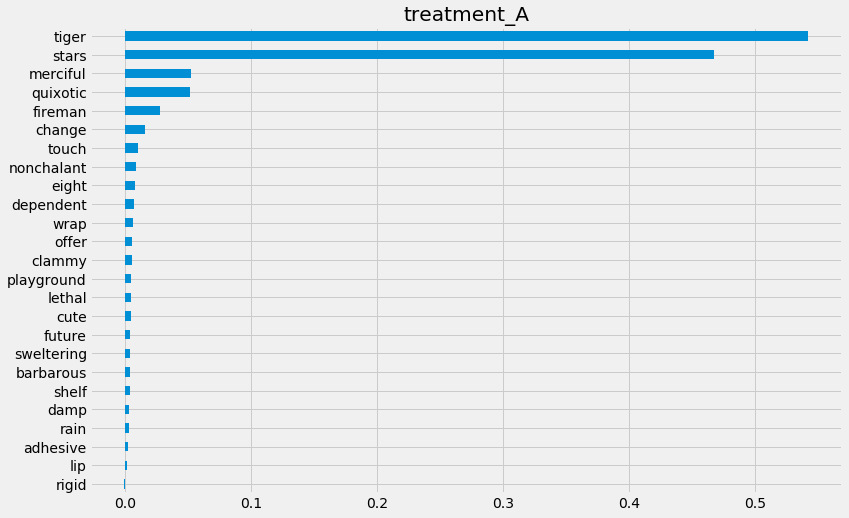

In [31]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [32]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 2.6981277465820312 seconds


In [33]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.542145
stars         0.467867
merciful      0.052725
quixotic      0.052160
fireman       0.028023
change        0.016190
touch         0.010718
nonchalant    0.008626
eight         0.007869
dependent     0.007420
wrap          0.006913
offer         0.005693
clammy        0.005449
playground    0.005034
lethal        0.004923
cute          0.004634
future        0.004429
sweltering    0.004285
barbarous     0.004236
shelf         0.003853
damp          0.003703
rain          0.003322
adhesive      0.002478
lip           0.001463
rigid        -0.000175
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

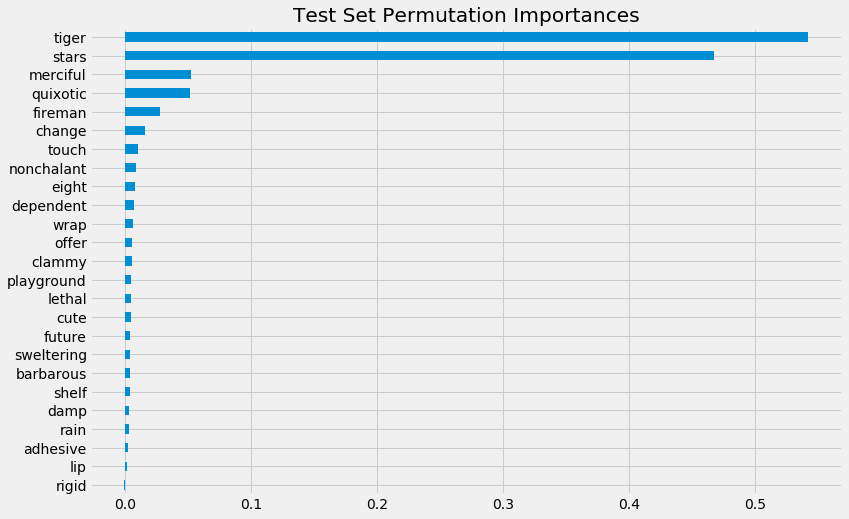

In [34]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [35]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[ 2.23895567e-01, -6.98016830e-02,  6.66056009e-02, ...,
          3.42849501e-05, -4.89155636e-03, -1.94508501e-03],
        [ 8.29988012e-02,  1.83765218e-01, -5.90301935e-02, ...,
          1.09675786e-03,  2.33757682e-03, -1.79593092e-03],
        [ 2.33977934e-01,  4.80451533e-02,  5.10472659e-03, ...,
         -5.19230274e-03,  1.69935484e-02, -1.86346890e-03],
        ...,
        [ 2.23726810e-01,  2.83999125e-01,  1.05957214e-02, ...,
         -4.40564369e-03,  3.63104522e-03, -7.79595271e-04],
        [ 1.82598989e-01, -1.86008617e-01,  2.21095145e-02, ...,
         -2.08611140e-03,  9.31929067e-03,  4.51260084e-03],
        [ 8.28411269e-02,  4.95341098e-02,  2.08908666e-02, ...,
         -1.20010459e-04, -2.08475022e-03, -2.78406599e-03]])}

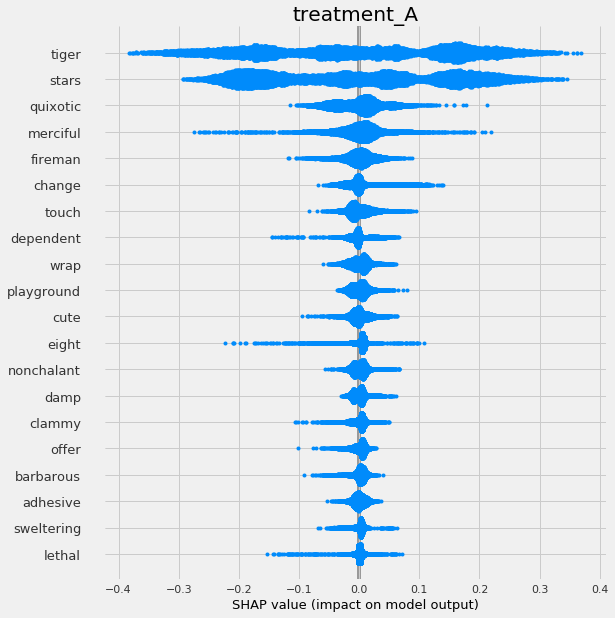

In [36]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

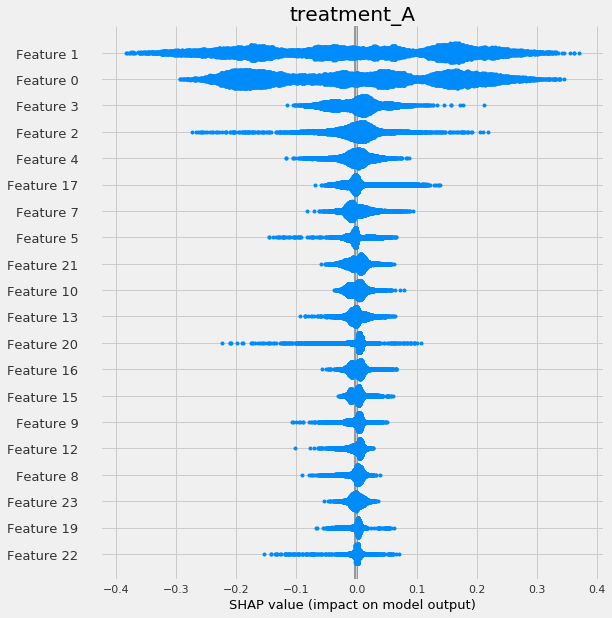

In [37]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

## X Learner

In [38]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

(array([0.52635073]), array([0.51271831]), array([0.53998316]))

In [39]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [40]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.413157
 stars         0.359466
 merciful      0.029364
 change        0.021216
 quixotic      0.017347
 touch         0.016293
 fireman       0.013874
 eight         0.013647
 adhesive      0.013040
 barbarous     0.011566
 damp          0.009279
 clammy        0.008334
 cute          0.008301
 wrap          0.008288
 dependent     0.007396
 playground    0.006204
 nonchalant    0.006183
 rigid         0.006077
 shelf         0.005574
 sweltering    0.005481
 offer         0.005114
 lethal        0.005065
 rain          0.003906
 lip           0.003356
 future        0.002472
 dtype: float64}

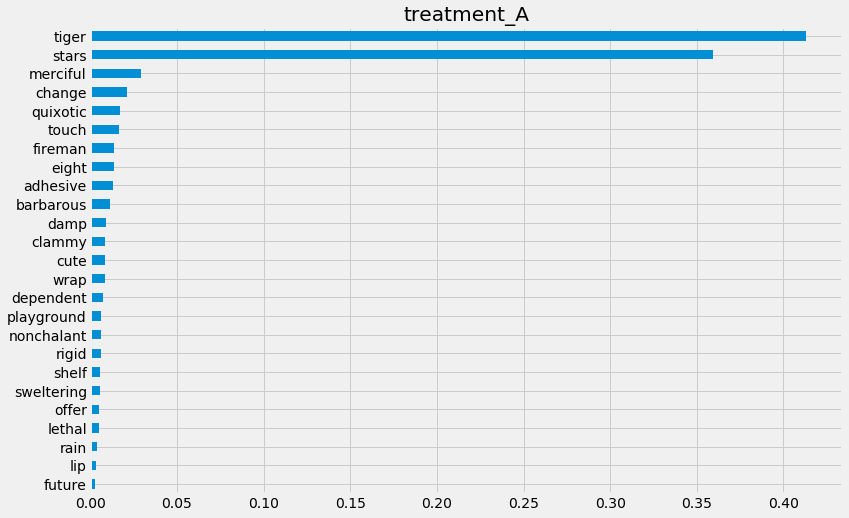

In [41]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [42]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.790118
 stars         0.657454
 merciful      0.031689
 quixotic      0.026451
 change        0.024444
 touch         0.019540
 adhesive      0.012644
 fireman       0.011609
 eight         0.010880
 damp          0.008791
 barbarous     0.008573
 nonchalant    0.007776
 wrap          0.006515
 dependent     0.005716
 playground    0.005185
 cute          0.004942
 clammy        0.004570
 rigid         0.004291
 sweltering    0.003877
 lethal        0.003752
 shelf         0.003285
 offer         0.002548
 lip           0.001531
 rain          0.000856
 future        0.000621
 dtype: float64}

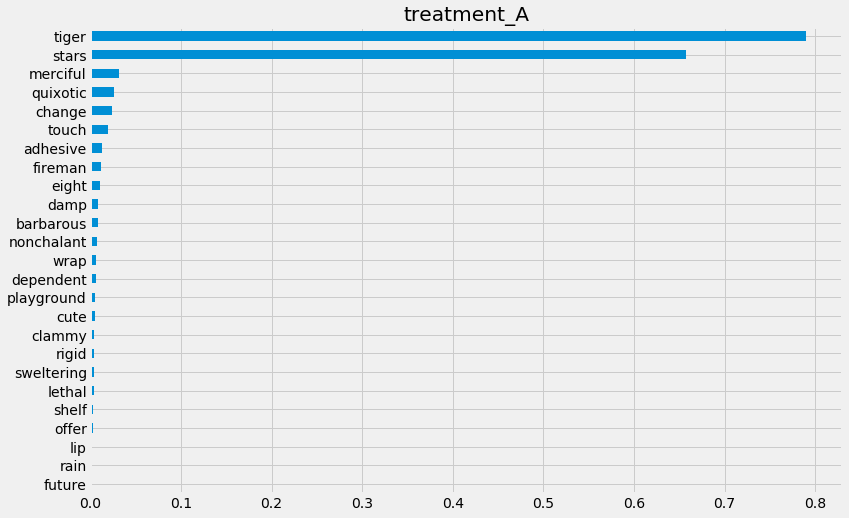

In [43]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [44]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.9017090797424316 seconds


In [45]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.790118
stars         0.657454
merciful      0.031689
quixotic      0.026451
change        0.024444
touch         0.019540
adhesive      0.012644
fireman       0.011609
eight         0.010880
damp          0.008791
barbarous     0.008573
nonchalant    0.007776
wrap          0.006515
dependent     0.005716
playground    0.005185
cute          0.004942
clammy        0.004570
rigid         0.004291
sweltering    0.003877
lethal        0.003752
shelf         0.003285
offer         0.002548
lip           0.001531
rain          0.000856
future        0.000621
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

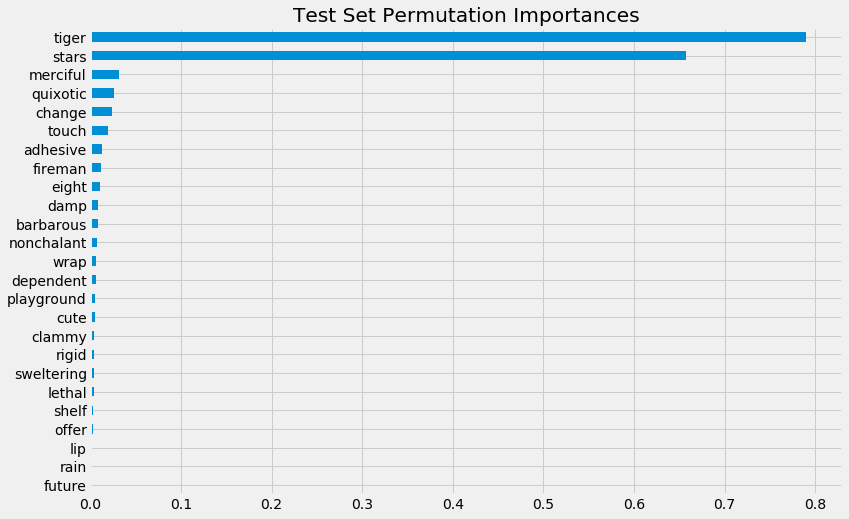

In [46]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [47]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[ 0.12076316, -0.05792336,  0.02906702, ...,  0.00665948,
         -0.01039702, -0.00043187],
        [ 0.03947314,  0.13257951, -0.0352313 , ...,  0.00135135,
         -0.00162266, -0.00127716],
        [ 0.13415539,  0.00655198,  0.00531122, ..., -0.00137835,
          0.0283614 , -0.00483927],
        ...,
        [ 0.23418565,  0.26383921,  0.00296239, ...,  0.0003731 ,
         -0.00863325, -0.00110156],
        [ 0.19065257, -0.14832322,  0.0125272 , ...,  0.00320624,
          0.02214994,  0.00257151],
        [ 0.05736145,  0.04083792,  0.01270311, ...,  0.00256949,
         -0.00833282,  0.00071824]])}

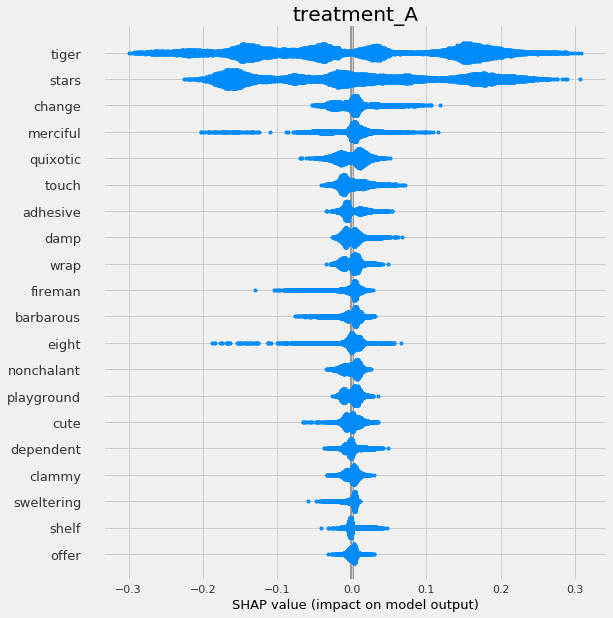

In [48]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

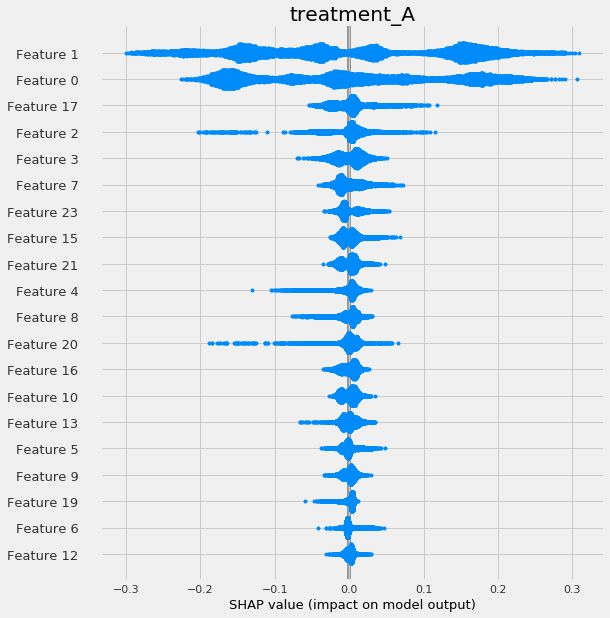

In [49]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

## R Learner

In [50]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=e_multi)

### Feature Importance (method = `auto`)

In [51]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.236119
 stars         0.187231
 merciful      0.048726
 change        0.043941
 touch         0.042460
 playground    0.039960
 cute          0.037151
 offer         0.028047
 barbarous     0.027472
 sweltering    0.026418
 adhesive      0.024631
 clammy        0.022468
 wrap          0.022425
 quixotic      0.021160
 nonchalant    0.021017
 dependent     0.020474
 lethal        0.019601
 fireman       0.019547
 lip           0.018586
 damp          0.017167
 shelf         0.017109
 eight         0.016680
 rigid         0.016609
 future        0.012659
 rain          0.012342
 dtype: float64}

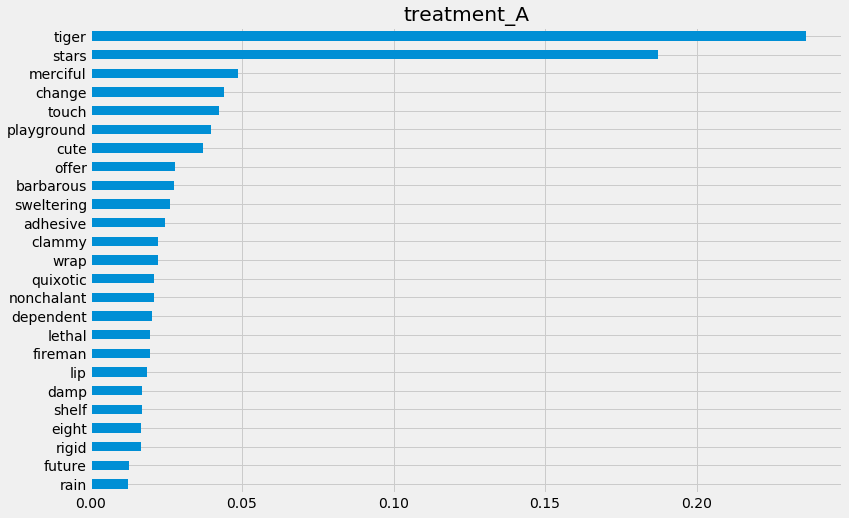

In [52]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [53]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': tiger         0.334549
 stars         0.246910
 merciful      0.039518
 change        0.037940
 touch         0.031415
 playground    0.029544
 cute          0.024985
 adhesive      0.016695
 sweltering    0.014847
 barbarous     0.014077
 nonchalant    0.011086
 wrap          0.010270
 fireman       0.010028
 dependent     0.009341
 quixotic      0.008749
 rain          0.008382
 lethal        0.008209
 offer         0.007923
 clammy        0.006927
 lip           0.006815
 shelf         0.006428
 rigid         0.005010
 eight         0.004826
 damp          0.003911
 future        0.003565
 dtype: float64}

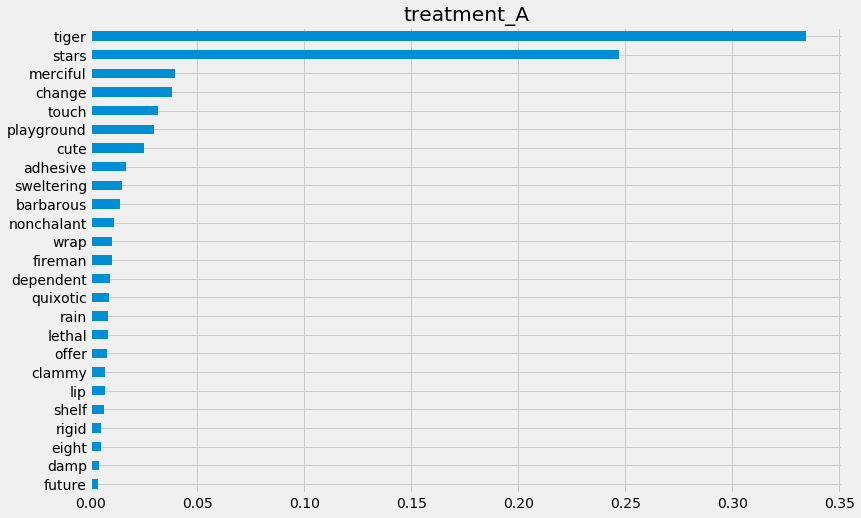

In [54]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [55]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.03749418258667 seconds


In [56]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.334549
stars         0.246910
merciful      0.039518
change        0.037940
touch         0.031415
playground    0.029544
cute          0.024985
adhesive      0.016695
sweltering    0.014847
barbarous     0.014077
nonchalant    0.011086
wrap          0.010270
fireman       0.010028
dependent     0.009341
quixotic      0.008749
rain          0.008382
lethal        0.008209
offer         0.007923
clammy        0.006927
lip           0.006815
shelf         0.006428
rigid         0.005010
eight         0.004826
damp          0.003911
future        0.003565
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

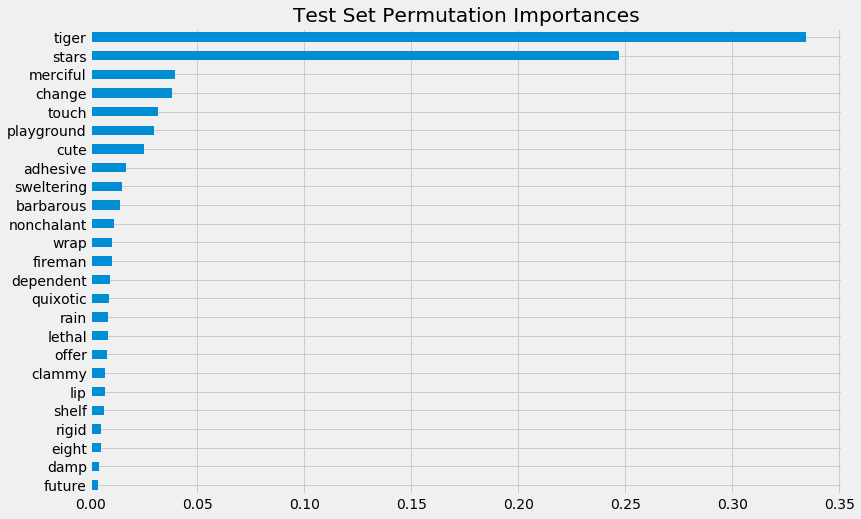

In [57]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [58]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[ 1.02894775e-01, -8.05449817e-02,  3.04355138e-02, ...,
          9.06141245e-03, -2.65595398e-02, -7.18443444e-03],
        [ 9.37017074e-03,  1.42539004e-01, -7.26851156e-02, ...,
         -1.61938371e-03, -2.10699106e-03, -3.47964030e-03],
        [ 1.78765111e-01, -8.01589569e-02,  4.60271178e-02, ...,
          6.87169631e-03,  3.64934038e-02, -1.65044199e-03],
        ...,
        [ 2.12922006e-01,  3.25138109e-01,  1.60017459e-02, ...,
          9.47591720e-03,  1.82383527e-03, -1.77858376e-03],
        [ 1.02421810e-01, -1.18504799e-01,  4.53390392e-03, ...,
          6.80744483e-03,  1.47400244e-02,  2.87801715e-03],
        [ 4.23080488e-02,  3.25438480e-02,  1.86015561e-02, ...,
          1.82458857e-03, -2.34528945e-03,  2.89855741e-04]])}

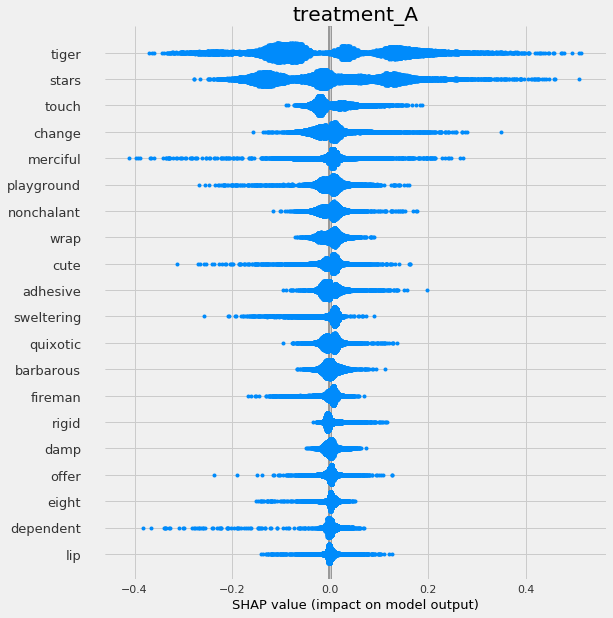

In [59]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

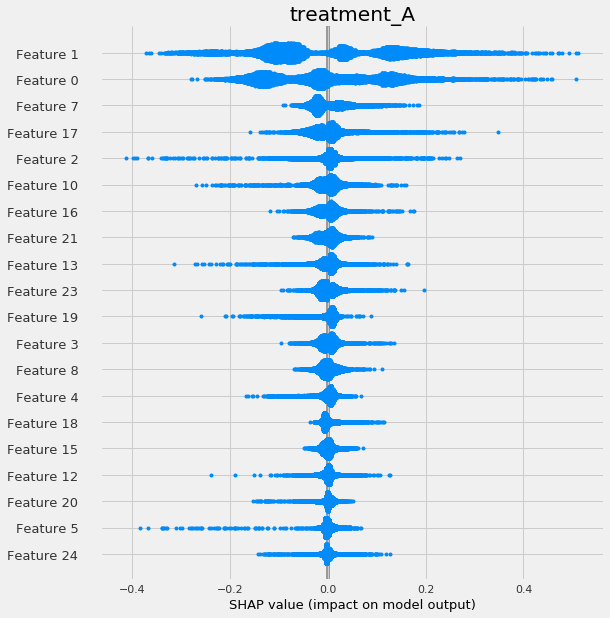

In [60]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)